# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
from scipy import linalg
from scipy import signal

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

# Plotting libraries and settings
import matplotlib.pyplot as plt
# from matplotlib import cm

# My own script (an interface to the simulator)
import ae353_spacecraft

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_spacecraft)

pybullet build time: Jan 28 2022 20:18:15


<module 'ae353_spacecraft' from '/Users/patrickthornton/Desktop/ae353 - Design Projects/ae353-DP3-spacecraft/ae353_spacecraft.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two optional arguments you may want to use:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `seed` (an integer, default `None`) is a seed to initialize the random number generator used by the simulator.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=None,
)

Here is how to find the location of each star:

In [3]:
for (i, star) in enumerate(simulator.stars):
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


## Define equations of motion for the dynamic model and construct $f$

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

In [24]:
### Specify the physical parameters:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

### Derive the equations of motion:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

f

Matrix([
[                        (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                     w_y*cos(phi) - w_z*sin(phi)],
[         w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

## Derive the sensor model and construct $g$

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

In [25]:
### Symbolic variables for the right ascension alpha and declination delta of each star:
alpha, delta = sym.symbols('alpha, delta')

### Specify the physical parameters:
# Scope radius
r = 0.8 / 2.1

### Derive the sensor model:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

## Define equilibrium point and verify that $f = 0$

In [26]:
psi_e = 0
theta_e = 0
phi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_1_e = 0
tau_2_e = 0
tau_3_e = 0
tau_4_e = 0

eq = {psi: psi_e, 
      theta: theta_e, 
      phi: phi_e, 
      w_x: w_x_e, 
      w_y: w_y_e, 
      w_z: w_z_e, 
      tau_1: tau_1_e, 
      tau_2: tau_2_e, 
      tau_3: tau_3_e, 
      tau_4: tau_4_e,
     }

f.subs(eq)

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

## Get symbolic forms of $A$ and $B$ and print $\LaTeX$–formatted text

In [42]:
from sympy.physics import mechanics
mechanics.init_vprinting()

A_sym = f.jacobian([psi, theta, phi, w_x, w_y, w_z]).subs(eq)
B_sym = f.jacobian([tau_1, tau_2, tau_3, tau_4]).subs(eq)

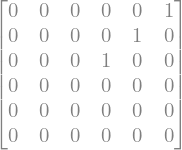

In [45]:
A_sym
# print(f'{mechanics.mlatex(A_sym.subs(eq))}')

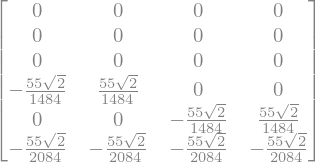

In [46]:
B_sym
# print(f'{mechanics.mlatex(B_sym.subs(eq))}')

## Define a function to return a state-space model for a given choice of equilibrium point.

In [47]:
def get_model(
    psi_e,
    theta_e,
    phi_e,
    w_x_e,
    w_y_e,
    w_z_e,
    tau_1_e,
    tau_2_e,
    tau_3_e,
    tau_4_e
    ):
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([psi, theta, phi, w_x, w_y, w_z])
    
    B_sym = f.jacobian([tau_1, tau_2, tau_3, tau_4])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], A_sym)
    
    B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e).astype(float)
    
    B = B_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e).astype(float)
    
    # Return A and B
    return A, B

In [49]:
A, B = get_model(
    psi_e,
    theta_e,
    phi_e,
    w_x_e,
    w_y_e,
    w_z_e,
    tau_1_e,
    tau_2_e,
    tau_3_e,
    tau_4_e
    )
print(f'A =\n{A}\n')
print(f'B =\n{B}\n')

A =
[[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1. -0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

B =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.        ]
 [ 0.          0.         -0.05241358  0.05241358]
 [-0.03732329 -0.03732329 -0.03732329 -0.03732329]]



## Determine if the system is controllable

Compute the controllability matrix $\boldsymbol{W}$ and confirm that it is full rank.

In [66]:
def get_W(A, B):
    n = A.shape[0]
    W = B
    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ B
        W = np.block([W, col])
    return W

W = get_W(A, B)
rank = np.linalg.matrix_rank(W)
print(f'Rank of controllability matrix = {rank}\n')
print(f'Largest possible rank = {A.shape[0]}\n')

Rank of controllability matrix = 6

Largest possible rank = 6



Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently.

In [ ]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        
        # FIXME: replace the following lines
        front_torque = 0.
        back_torque = 0.
        left_torque = 0.
        right_torque = 0.
        
        
        return front_torque, back_torque, left_torque, right_torque

Create an instance of the controller.

In [ ]:
controller = Controller()

You could reset the simulator with given initial conditions, optionally specifying scope noise (default is `0.1`), i.e., the standard deviation of the $y$ and $z$ components of each star tracker measurement.

In [ ]:
simulator.reset(
    orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=0.1,
)

Or, you could reset the simulator with initial conditions sampled at random.

In [ ]:
simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)

Reset the controller.

In [ ]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [ ]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

In [ ]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['front_torque'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['back_torque'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['left_torque'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['right_torque'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)